# Making a package for systematics analysis

The idea of this notebook is to take a fully-converged MCMC fit and produce a package of data files suitable for analyzing the unmodelled systematics remaining in the data. It should contain:

* The best-fit parameter names, values, and uncertainties (covariance matrix)
* Names, values, and uncertainties on any parameters obtained by linear fitting
* Names, values, and uncertainties for derived parameters
* The astrometric parameters that went into the calculation
* The settings used in the fitting
* Residuals of the fitting, in the form of a matrix with columns time, residual (phase), uncertainty
* Derivatives of the residuals with respect to all fitted parameters
* Derivatives of an imaginary uniformly sampled data set with respect to all fitted parameters


In [142]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [143]:
from glob import glob
import os
import time
import cPickle as pickle
import joblib

import scipy.linalg
import scipy.stats

import emcee
import numdifftools

import kepler
import threebody

In [144]:
import matplotlib
matplotlib.rcParams['savefig.dpi'] = 144
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.viridis()

In [145]:
gr_params = dict(files="tuned2_aligned_pulses_1400",
                     tzrmjd_middle='auto',
                     parfile="0337_tempo2_px_optical_dmcorr.par",
                     fit_pos=True,
                     fit_pm=True,
                     fit_px=True,
                     t2_astrometry=True,
                     efac=1,
                     kopeikin=False,
                     ppn_mode='GR',
                     linear_jumps=True,
                     linear_dm=True,
                     toa_mode="pipeline")
F_gr = threebody.Fitter(**gr_params)
params = gr_params.copy()
params["ppn_mode"] = "heavysimple"
F = threebody.Fitter(**params)
F.best_parameters = F_gr.best_parameters
F.best_parameters["ppn_mode"] = "heavysimple"
F.best_parameters["delta"] = 0
F.best_parameters["dbeta"] = 0
F.best_parameters["dgamma"] = 0
fitter_params = params

In [146]:
F.best_parameters

{'acosi_i': 1.4917556831389759115,
 'acosi_o': 91.537221246828303294,
 'asini_i': 1.2175268329475218036,
 'asini_o': 74.672701686174651384,
 'dbeta': 0,
 'delta': 0,
 'delta_lan': -9.4422373308373459869e-06,
 'dgamma': 0,
 'eps1_i': 0.00068720427648491836997,
 'eps1_o': 0.035186232997562914975,
 'eps2_i': -9.1389372945032599227e-05,
 'eps2_o': -0.0034622144873393889656,
 'pb_i': 1.6293969535025763899,
 'pb_o': 327.25748573222122784,
 'ppn_mode': 'heavysimple',
 'q_i': 0.13726703803140972169,
 'tasc_i': 0.40771702655161606079,
 'tasc_o': 313.93575715644124929}

In [147]:
F.goodness_of_fit(F.best_parameters)

58246.078804751926477

In [148]:
orbit = F.compute_orbit(F.best_parameters)
orbit

{'initial_values': array([  1.13481072e+02,   2.15989003e+01,   1.76181073e+01,
          6.76377888e+00,   1.69508381e+00,   1.38279225e+00,
          1.44382010e+00,   1.13478854e+02,   3.39666940e+01,
          2.77123345e+01,  -5.47119076e+01,   1.69281752e+00,
          1.38094257e+00,   1.98188909e-01,  -4.52788302e+02,
         -9.21357852e+01,  -7.51575005e+01,   2.61854604e+00,
         -6.76229134e+00,  -5.51644897e+00,   4.11531180e-01,
          0.00000000e+00]),
 'n_evaluations': 1607198,
 'parameter_dict': {'acosi_i': 1.4917556831389759115,
  'acosi_o': 91.537221246828303294,
  'asini_i': 1.2175268329475218036,
  'asini_o': 74.672701686174651384,
  'dbeta': 0,
  'delta': 0,
  'delta_lan': -9.4422373308373459869e-06,
  'dgamma': 0,
  'eps1_i': 0.00068720427648491836997,
  'eps1_o': 0.035186232997562914975,
  'eps2_i': -9.1389372945032599227e-05,
  'eps2_o': -0.0034622144873393889656,
  'general': True,
  'kopeikin': False,
  'matrix_mode': 0,
  'pb_i': 1.629396953502576389

58246.0788048 27535


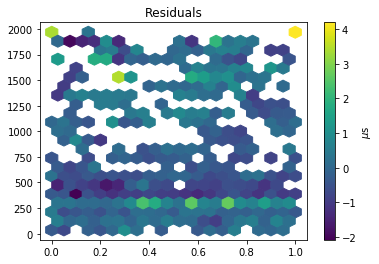

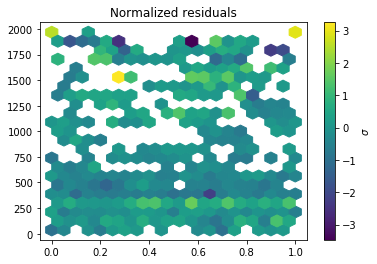

In [150]:
residuals = F.residuals()
plt.hexbin(
    ((F.mjds-F.base_mjd-F.best_parameters['tasc_i'])/F.best_parameters['pb_i'])%1, 
    F.mjds,
    C=residuals/F.reference_f0*1e6, gridsize=20)
plt.title("Residuals")
plt.colorbar().set_label(r"$\mu$s")
plt.figure()
plt.hexbin(
    ((F.mjds-F.base_mjd-F.best_parameters['tasc_i'])/F.best_parameters['pb_i'])%1, 
    F.mjds,
    C=residuals/F.phase_uncerts, gridsize=20)
plt.title("Normalized residuals")
plt.colorbar().set_label(r"$\sigma$")

print np.sum((residuals/F.phase_uncerts)**2), len(F.mjds)

In [151]:
M, linear_parameters = F.compute_linear_matrix()
linear_parameters

['d_DECJ',
 'd_DM',
 'd_PMDEC',
 'd_PMRA',
 'd_PX',
 'd_RAJ',
 'f0',
 'f1',
 'j_GBT_1400',
 'j_WSRT_1400',
 'phase']

In [152]:
M.shape

(27535, 11)

In [153]:
derivatives = {}

In [154]:
for i, p in enumerate(linear_parameters):
    derivatives[p] = M[:,i]

## New approach

One derivative at a time; parallelization possible

In [155]:
nl_der = {}

In [156]:
base_steps = dict(asini_i=1e-4, 
                  pb_i=1e-6, 
                  eps1_i=1e-4, 
                  eps2_i=1e-4,
                  tasc_i=1e-4,
                  pb_o=1e-4,
                  delta=1e-6,
                  eps2_o=1e-5,
                  eps1_o=1e-5,
                  
                  )

In [157]:
F.parameters

['asini_i',
 'pb_i',
 'eps1_i',
 'eps2_i',
 'tasc_i',
 'acosi_i',
 'q_i',
 'asini_o',
 'pb_o',
 'eps1_o',
 'eps2_o',
 'tasc_o',
 'acosi_o',
 'delta_lan',
 'delta',
 'dgamma',
 'dbeta']

In [161]:
print F.goodness_of_fit(F.best_parameters)
for p in F.parameters:
    if p in nl_der:
        print "skipping", p
        continue
    bs = base_steps.get(p, 1e-3)
    sg = numdifftools.MaxStepGenerator(bs,
                                       use_exact_steps=True)
    def fres(v):
        bp  = F.best_parameters.copy()
        print p, bp[p], v,
        bp[p] += v
        try:
            r = F.residuals(bp)
            print F.goodness_of_fit(bp)
            return r
        except ValueError:
            print np.inf
            return np.inf*np.ones_like(F.mjds)
    nl_der[p] = numdifftools.Derivative(fres, step=sg)(0)


58246.0788048
skipping asini_i
skipping pb_i
skipping eps1_i
skipping eps2_i
skipping tasc_i
skipping acosi_i
skipping q_i
skipping asini_o
skipping pb_o
skipping eps1_o
skipping eps2_o
skipping tasc_o
skipping acosi_o
skipping delta_lan
skipping delta
skipping dgamma
skipping dbeta


In [162]:
derivatives.update(nl_der)

## Annotating TOAs

In [163]:
extra = derivatives.copy()

toa_info = F.annotated_toas(extra, residuals=residuals)

## Exporting the information


In [164]:
np.savez_compressed(
    "systematics-package.npz",
    fitter_params=fitter_params,
    best_parameters=F.best_parameters,
    residuals=residuals,
    telescopes=F.tels,
    telescope_list=F.tel_list,
    orbit=orbit,
    times=F.mjds,
    base_mjd=F.base_mjd,
    phase_uncerts=F.phase_uncerts,
    linear_parameters=linear_parameters,
    derivatives=derivatives,
    toa_info=toa_info,
    )

In [179]:
d = dict(
    fitter_params=fitter_params,
    best_parameters=F.best_parameters,
    residuals=residuals,
    telescopes=F.tels,
    telescope_list=F.tel_list,
    f0=F.reference_f0,
    efacs=fitter_params['efac'],
    orbit=orbit,
    times=F.mjds,
    base_mjd=F.base_mjd,
    phase_uncerts=F.phase_uncerts,
    linear_parameters=linear_parameters,
    derivatives=derivatives,
    toa_info=toa_info,
    )
with open("systematics-package.pickle","wb") as f:
    pickle.dump(d,f)

## Checking the quality of the derivatives and the fit

In [174]:
params = F.parameters + linear_parameters
exclude = ["delta","dbeta","dgamma"]
#exlcude = []
trim_params = [p for p in params if p not in exclude]
Abig = np.array([derivatives[p] 
                 for p in trim_params], 
                dtype=np.longdouble).T
print(Abig.shape)
r = threebody.lstsq_with_errors(Abig, residuals, F.phase_uncerts)
for i,p in enumerate(trim_params):
    print p, threebody.fmt(r.x[i], r.uncerts[i])
print r.singular_values

(27535, 25)
asini_i 9.6(9)e-8
pb_i 1.39(3)e-8
eps1_i 5.4(10)e-8
eps2_i -1.13(10)e-7
tasc_i 9.0(6)e-8
acosi_i -3.0(3)e-4
q_i -1.82(3)e-4
asini_o -2.04(10)e-6
pb_o -3.46(3)e-5
eps1_o -1.35(3)e-8
eps2_o -7.34(9)e-8
tasc_o -3.73(4)e-5
acosi_o 1.7(3)e-4
delta_lan -6.7(7)e-6
d_DECJ 0(16)e-8
d_DM 0(3)e-3
d_PMDEC 0(3)e-10
d_PMRA -2(6)e-11
d_PX -3(4)e0
d_RAJ 0(4)e-8
f0 -2.0(18)e-13
f1 -1.4(11)e-21
j_GBT_1400 0(4)e-6
j_WSRT_1400 1(10)e-6
phase 1.1(9)e-5
[ 2.19696701  2.11502212  1.77758032  1.52106012  1.37486303  1.3246788
  1.07633781  1.06695629  0.96565362  0.92910412  0.85455834  0.78845561
  0.76542565  0.47026405  0.39451284  0.23130982  0.17056542  0.16044611
  0.15325953  0.12469842  0.11403217  0.10139219  0.05926827  0.01318869
  0.00369861]


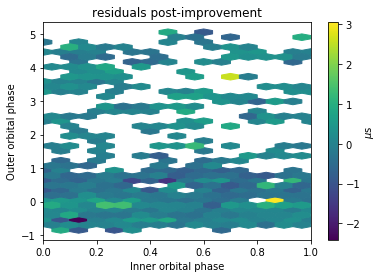

In [175]:
threebody.hexplot(F.best_parameters, F.mjds, 
                  r.residuals/F.reference_f0*1e6, 
                  gridsize=(15,20))
plt.colorbar(label=r"$\mu$s")
plt.title("residuals post-improvement")

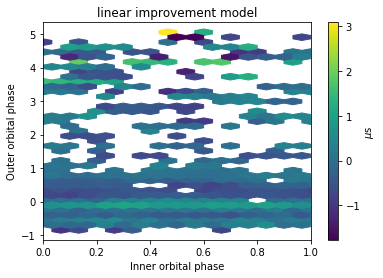

In [176]:
v = (residuals-r.residuals)
threebody.hexplot(F.best_parameters, F.mjds, 
                  v/F.reference_f0*1e6, 
                  gridsize=(15,20))
plt.colorbar(label=r"$\mu$s")
plt.title("linear improvement model")

In [178]:
bp = F.best_parameters.copy()
for p in F.parameters:
    i = params.index(p)
    bp[p] -= r.x[i]
pre = F.goodness_of_fit(F.best_parameters)
print "pre-improvement:", pre
post = F.goodness_of_fit(bp)
print "post-improvement:", post
if post<pre:
    with open("derivative-best-parameters.pickle","wb") as f:
        pickle.dump(bp, f)

pre-improvement: 58246.0788048
post-improvement: 193392144.487


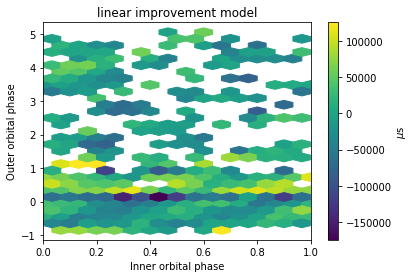

In [173]:
A = np.array([derivatives[p] 
              for p in derivatives.keys() if p!="delta"]).T
b = derivatives["delta"]
r = threebody.lstsq_with_errors(A, b, F.phase_uncerts)
v = r.residuals
threebody.hexplot(F.best_parameters, F.mjds, 
                  v/F.reference_f0*1e6, 
                  gridsize=(15,15))
plt.colorbar(label=r"$\mu$s")
plt.title("linear improvement model")

In [113]:
for n in range(3,15):
    xs = np.linspace(-100,100,10000,dtype=np.longdouble)
    A = np.array([xs**i for i in range(n+1)]).T
    b = (xs+1)**i
    r = threebody.lstsq_with_errors(A,b)
    print n, r.x, r.singular_values[0]/r.singular_values[-1]

3 [ 1.0  3.0  3.0  1.0] 4.79128803045
4 [ 1.0  4.0  6.0  4.0  1.0] 10.9981299065
5 [ 1.0  5.0  10.0  10.0  5.0  1.0] 23.8213002303
6 [ 1.0  6.0  15.0  20.0  15.0  6.0  1.0] 55.4693437615
7 [ 1.0  7.0  21.0  35.0  35.0  21.0  7.0  1.0] 125.511569106
8 [ 1.0000008  8.0000001  28.0  56.0  70.0  56.0  28.0  8.0  1.0] 294.69216867
9 [ 1.0001421  9.0000154  35.999999  84.0  126.0  126.0  84.0  36.0  9.0  1.0] 680.060311603
10 [ 0.99650436  9.9977462  45.000027  120.0  210.0  252.0  210.0  120.0  45.0
  10.0  1.0] 1604.6213237
11 [ 2.1730668  10.941461  54.992041  165.00019  330.00001  462.0  462.0
  330.0  165.0  55.0  11.0  1.0] 3743.97728121
12 [ 264.61859  10.881026  63.662895  219.99735  495.00326  792.00001  924.0
  792.0  495.0  220.0  66.0  12.0  1.0] 8863.9292357
13 [ 7102.241 -4792.839  31.769982  302.38535  715.04117  1286.9844  1716.0
  1716.0  1287.0  715.0  286.0  78.0  13.0  1.0] 20825.1739258
14 [-1760130.4  471410.71  21430.478 -1183.0441  959.6278  2003.4132
  3003.0296  343